# Climate Change: Earth Surface Temperatures

## Introduction
Using over 100 years of weather data, we will attempt to predict the average worldwide land and ocean temperature. We're going to pretend we don't have access to weather forecasts. We do, however, have access to a century's worth of historical global temperature averages, including global maximum and minimum temperatures, as well as global land and ocean temperatures. With all of this information, we may conclude that this is a supervised, regression machine learning problem.

This falls under the realm of supervised learning, given that we possess both the features and the target variable for prediction. The task takes on a regression nature because the target variable is continuous. In the training phase, multiple regression models are exposed to both features and targets, and they are tasked with learning how to effectively map the data to make predictions. Emphasizing the continuous nature of the target value further characterizes this as a regression task, setting it apart from classification tasks, where discrete classes are typically involved.

![Temperature Change](https://cff2.earth.com/uploads/2019/06/18173504/Harvard-scientist-We-have-5-years-to-mitigate-the-worst-of-climate-change-960x640.jpg)

Image Source: [Earth.com](https://www.earth.com/news/5-years-mitigate-climate-change/)

## Table of Contents
---
- [Introduction](#Introduction)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Cleaning](#Data-Cleaning)
- [Data Visualization](#Data-Visualization)
- [Model Preparation](#Model-Preparation)
- [Model Results](#Model-Results)
- [Discussion and recommendations](#Discussion-and-recommendations)

## Exploratory Data Analysis
Let's first import relevant libraries.

In [29]:
import pandas as pd
import plotly.express as px
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go

Next, load the temperature data. We will be working with the [Berkeley Earth Climate Change: Earth Surface Temperature Dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data) from Kaggle. This dataset contains Global Land and Ocean-and-Land Temperatures in a file named `GlobalTemperatures.csv`.

In [2]:
# Get data from global temperatures
temperature_df = pd.read_csv('GlobalTemperatures.csv')

# Look at shape of the dataframe
temperature_df.shape

(3192, 9)

In [3]:
temperature_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


We can see that there are 3192 records and 9 columns. Eight columns are numeric and represent continuous data while the `dt` column stores dates as objects in the form of `YYYY-MM-DD`. The column data is as follows:

>- `dt:` starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
- `LandAverageTemperature:` global average land temperature in celsius
- `LandAverageTemperatureUncertainty:` the 95% confidence interval around the average
- `LandMaxTemperature:` global average maximum land temperature in celsius
- `LandMaxTemperatureUncertainty:` the 95% confidence interval around the maximum land temperature
- `LandMinTemperature:` global average minimum land temperature in celsius
- `LandMinTemperatureUncertainty:` the 95% confidence interval around the minimum land temperature
- `LandAndOceanAverageTemperature:` global average land and ocean temperature in celsius
- `LandAndOceanAverageTemperatureUncertainty:` the 95% confidence interval around the global average land and ocean temperature


To make things easier to interpet, we will create a function which converts the temperature from Celsius to Fahrenheit.

In [5]:
def convertTemptToFahrenheit(temp):
  tempInFahrenheit = (temp * 1.8) + 32
  return tempInFahrenheit

# Convert specific numerical columns from  Celsius to Fahrenheit
# temperature_df_numerical_features = temperature_df.select_dtypes(include='number') # we don't want to convert the uncertainty columns!
numerical_cols = ['LandAverageTemperature','LandMaxTemperature','LandMinTemperature','LandAndOceanAverageTemperature']
temperature_df[numerical_cols] = temperature_df[numerical_cols].apply(convertTemptToFahrenheit)

And we will convert the `dt` column to a DateTime object. We will only be concerned with temperature data for every individual year.


In [6]:
def converToDateTime(df):
  df = df.copy()
  df['dt'] = pd.to_datetime(df['dt'])
  df['Month'] = df['dt'].dt.month
  df['Year'] = df['dt'].dt.year
  return df

# Convert date to a DateTime object
new_temp_df = converToDateTime(temperature_df)
# Drop Date and Months
new_temp_df = new_temp_df.drop(['dt', 'Month'], axis=1)
# Set the index of the dataframe to Year
new_temp_df = new_temp_df.set_index('Year')
new_temp_df.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Year,,,,,,,,
1750,37.4612,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750,37.5494,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750,42.1268,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750,47.2820,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750,52.8314,2.072,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

We will first examine all of the missing data.

In [7]:
new_temp_df.isnull().sum()

LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

We see that the columns `LandMaxTemperature`, `LandMaxTemperatureUncertainty`, `LandMinTemperature`, `LandMinTemperatureUncertainty`, `LandAndOceanAverageTemperature`, and `LandAndOceanAverageTemperatureUncertainty` all have 1200 missing records. This is because the data dictionary tells us that many of the numerical columns started receiving data around 1850. Lets verify this.

In [24]:
print("Land records start from:", new_temp_df[new_temp_df.LandAverageTemperature.notna()].index.min())
print("Ocean records start from:", new_temp_df[new_temp_df.LandAndOceanAverageTemperature.notna()].index.min())

Land records start from: 1750
Ocean records start from: 1850


We should therefore only accept records past 1850.

In [9]:
temp_df_cleaned = new_temp_df[new_temp_df.index >=1850]
temp_df_cleaned.isnull().sum()

LandAverageTemperature                       0
LandAverageTemperatureUncertainty            0
LandMaxTemperature                           0
LandMaxTemperatureUncertainty                0
LandMinTemperature                           0
LandMinTemperatureUncertainty                0
LandAndOceanAverageTemperature               0
LandAndOceanAverageTemperatureUncertainty    0
dtype: int64

In [10]:
temp_df_cleaned.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
Year,,,,,,,,
1850,33.3482,1.105,46.8356,1.738,26.2292,2.822,55.0994,0.367
1850,37.5278,1.275,49.9460,3.007,27.8762,1.623,56.4584,0.414
1850,40.9172,0.955,50.6246,2.401,28.5710,1.410,57.2774,0.341
1850,44.9906,0.665,55.2812,1.004,33.8324,1.329,58.4006,0.267
1850,50.0072,0.617,60.1790,2.406,38.8598,1.347,59.9126,0.249


In [11]:
temp_df_cleaned.shape

(1992, 8)

We can now see that we have cleaned the missing data and that we now have 1908 records for the eight numerical columns.

## Data Visualization

We will now use the existing temperature data to visualize the average temperature every year. Lets create a line plot of the land data and then the combined land and ocean data.

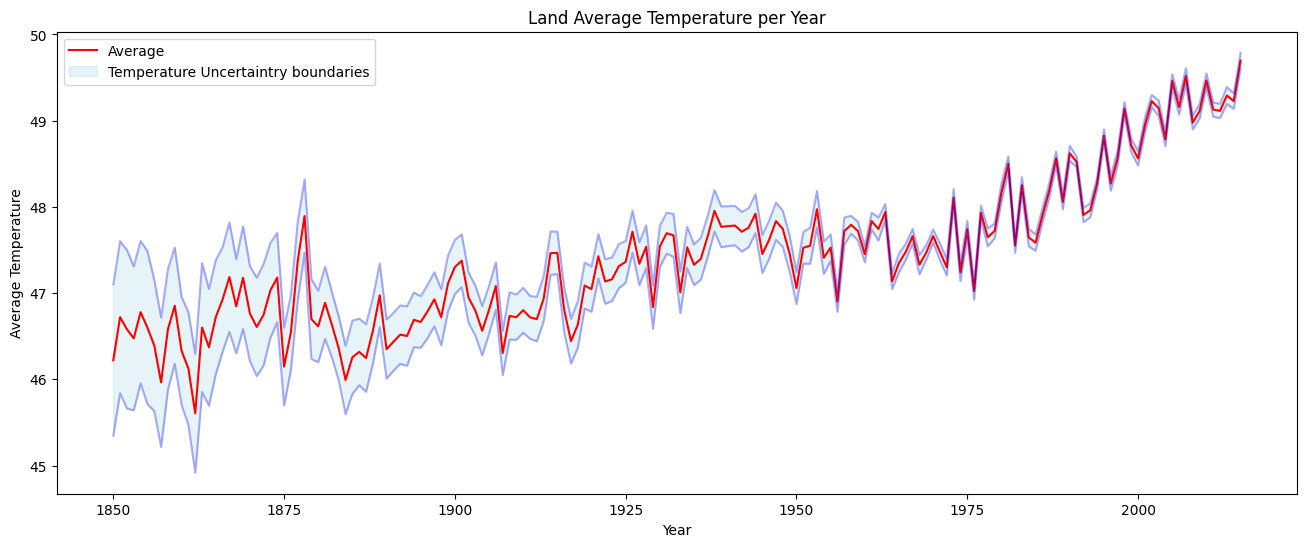

In [13]:
def plot_average_temp(df,col1,col2,label):
  cols = [col1,col2]
  temp_df = df[cols]
  average_per_year = temp_df.groupby(temp_df.index)[cols].mean()
  average_per_year['lower temp'] = average_per_year[col1] - average_per_year[col2]
  average_per_year['upper temp'] = average_per_year[col1] + average_per_year[col2]

  plt.figure(figsize=(16,6))
  plt.plot(average_per_year.index, average_per_year[col1], color='red', label='Average')
  plt.plot(average_per_year.index, average_per_year['upper temp'], color='blue', alpha=0.3)
  plt.plot(average_per_year.index, average_per_year['lower temp'], color='blue', alpha=0.3)
  plt.fill_between(average_per_year.index, average_per_year['upper temp'], average_per_year['lower temp'], color='lightblue', alpha=0.3, label='Temperature Uncertaintry boundaries')
  plt.xlabel('Year')
  plt.ylabel('Average Temperature')
  plt.title(label)
  plt.legend(loc='best')

# Land Average Temperature
plot_average_temp(temp_df_cleaned,'LandAverageTemperature','LandAverageTemperatureUncertainty','Land Average Temperature per Year')

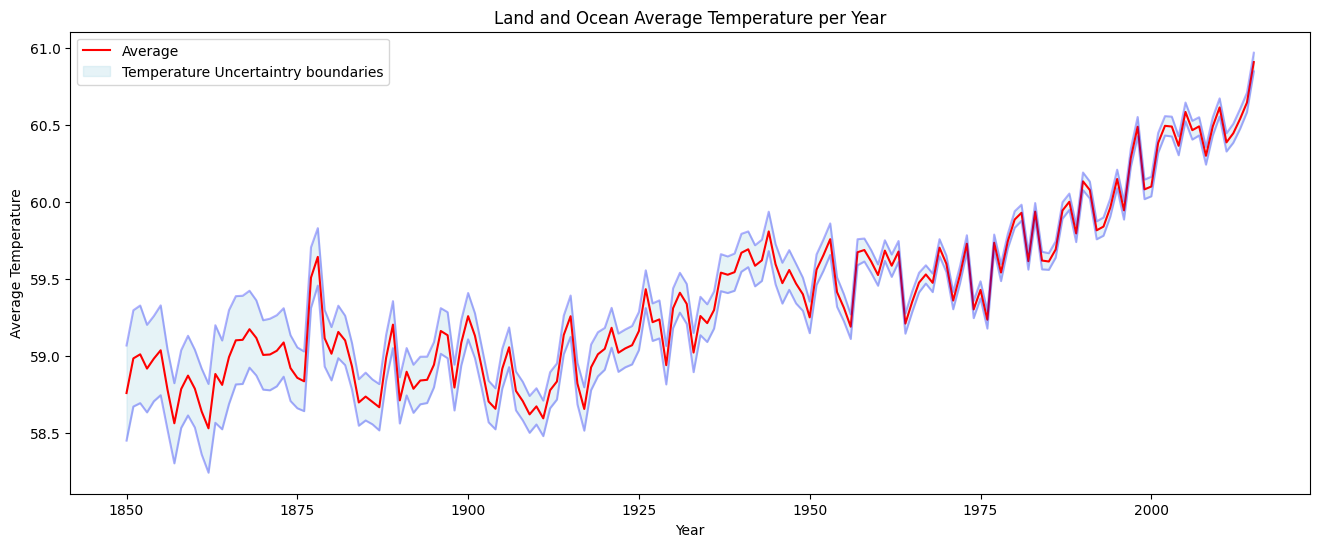

In [14]:
# Land and Ocean Average Temperature
plot_average_temp(temp_df_cleaned,'LandAndOceanAverageTemperature','LandAndOceanAverageTemperatureUncertainty','Land and Ocean Average Temperature per Year')

From these two plots, it is clear that the average temperature has increased by both land and sea from 1850 until now.

As we are working with a regression problem, it is a good idea to use a heatmap to visualize correlation between columns. We will look at the correlation between all numerical columns and the `LandAndOceanAverageTemperature` column (which will be the target variable in our machine learning models).

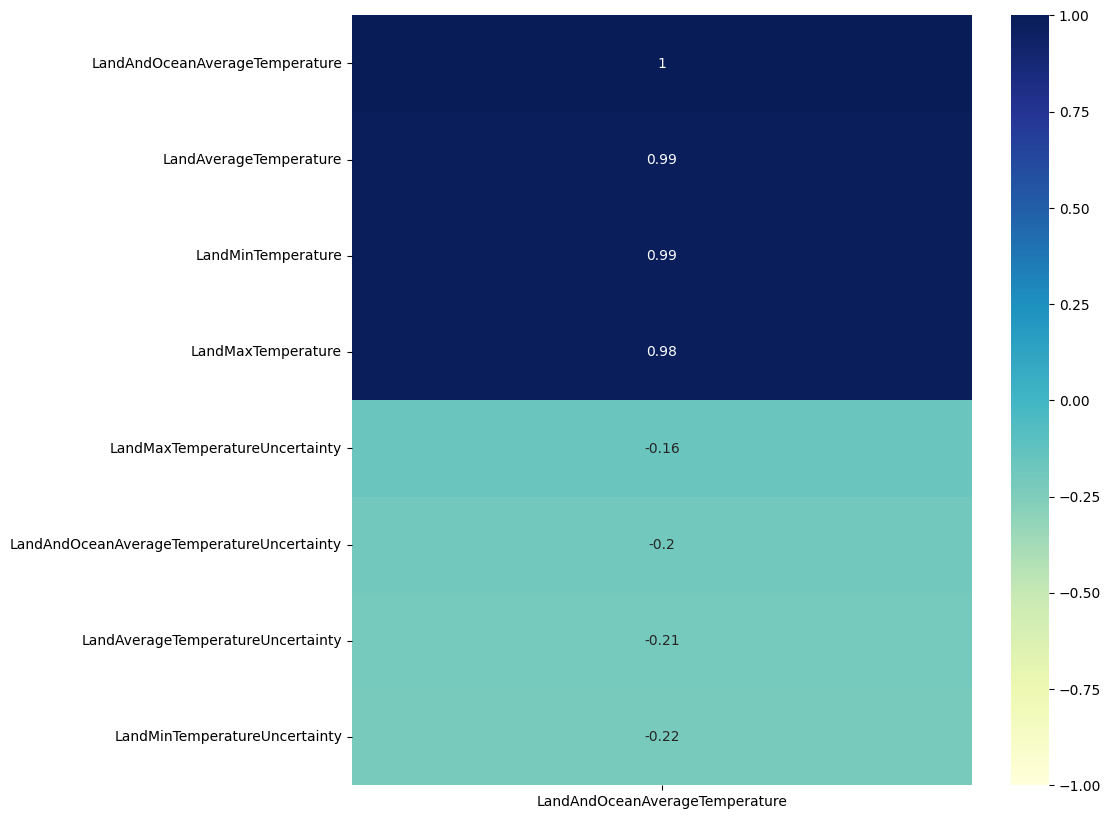

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
corr_matrix = np.abs(temp_df_cleaned.corr())
sns.heatmap(temp_df_cleaned.corr()[['LandAndOceanAverageTemperature']].sort_values('LandAndOceanAverageTemperature').tail(10),
 vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

Here we see that highly correlated features are `LandAverageTemperature`, `LandMinTemperature`, and `LandMaxTemperature.` Features that are less correlated are `LandMaxTemperatureUncertainty`, `LandAndOceanAverageTemperatureUncertainty`, `LandAverageTemperatureUncertainty`, and `LandMinTemperatureUncertainty`. We will drop these columns.

In [25]:
def reduce_df(df):
  # Create a copy of the original dataframe
  df = df.copy()

  # Drop LandMaxTemperatureUncertainty, LandAndOceanAverageTemperatureUncertainty,
  # LandMinTemperatureUncertainty and LandMinTemperatureUncertainty
  cols_to_drop = ['LandMaxTemperatureUncertainty','LandAndOceanAverageTemperatureUncertainty',
                'LandAverageTemperatureUncertainty','LandMinTemperatureUncertainty']
  df = df.drop(cols_to_drop,axis=1)
  return df

reduced_temperature_df = reduce_df(temp_df_cleaned)

## Model Preparation

We will now separate our data into features and a target. We will choose the average land and ocean temperature as our target variable. The features will be the remaining three columns which we will use to predict the average land and ocean temperature.

In [26]:
# Features, X
X = reduced_temperature_df.drop('LandAndOceanAverageTemperature',axis=1)
# Target, Y
Y = reduced_temperature_df['LandAndOceanAverageTemperature']

Next, let's split our data into train and test and look at the shape of the resulting datasets.

In [28]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3, random_state=40)
print("Size of X_Train: ", X_Train.shape)
print("Size of X_Test: ", X_Test.shape)
print("Size of Y_Train: ", Y_Train.shape)
print("Size of Y_Test: ", Y_Test.shape)

Size of X_Train:  (1394, 3)
Size of X_Test:  (598, 3)
Size of Y_Train:  (1394,)
Size of Y_Test:  (598,)


Before we start building various machine learning models, we will look at a baseline model to see how well our models perform. Our baseline will be the yearly average temperature (i.e., what would occur if we used the average temperature in `Y_Train` to predict the temperature).

In [31]:
Y_Pred = [Y_Train.mean()] * len(Y_Train)

# MAE
print('Base MAE (in degrees):', round(mean_absolute_error(Y_Train,Y_Pred),2))

Base MAE (in degrees): 2.03


Thus, we see that our machine learning models must beat a baseline MAE of ~2 degrees.

## Model Results